## Imports of modules and Libraries

In [85]:
!pip install --upgrade numpy==1.26.4
import numpy as np
print(np.__version__)

1.26.4



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\PJShih\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [86]:

!pip install pmdarima
import pmdarima as pm
print("pmdarima version:", pm.__version__)
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from warnings import filterwarnings
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from datetime import date, datetime


pmdarima version: 2.0.4



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\PJShih\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Indicate Whether to Include Weekends

In [87]:
include_weekends = True 

## Data Cleaning


In [88]:
!pip install openpyxl
import openpyxl
excel_file = pd.ExcelFile(r"C:\Users\PJShih\Downloads\forecasting demand data_ 2021-04-01 to 2024-03-31.xlsx")



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\PJShih\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [89]:
df_lst = []
df_name_lst = []

for sheet_name in excel_file.sheet_names:
    try:
        df = excel_file.parse(sheet_name)  # Read each sheet into a DataFrame
        df.to_csv(f"{sheet_name}.csv", index=False)
        df_lst.append(df)
        df_name_lst.append(sheet_name)
    except Exception as e:
        print(f"Error reading sheet {sheet_name}: {e}")

In [ ]:
df_lst_rev = []

# Step 1: Get the earliest year to use as a base
all_years = [pd.to_datetime(df.iloc[:, 0]).dt.isocalendar().year.min() for df in df_lst]
base_year = min(all_years)

for df in df_lst:
    df2 = df.iloc[:, [0,1,2]].copy()

    # Convert to datetime once
    dt = pd.to_datetime(df2.iloc[:, 0])
    iso = dt.dt.isocalendar()

    # Calculate cumulative week number
    df2['cumulative_week'] = (iso.year - base_year) * 52 + iso.week

    df_lst_rev.append(df2)

In [ ]:
def add_first_day_and_avg_no_duplicates(df, exclude_weekends_bool):
    # Convert 'calendar_dt' to datetime if not already
    if exclude_weekends_bool:
        df = df[~df["day_Of_week"].isin(["Saturday", "Sunday"])]
    print(df)
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])


    # Calculate the average requests per week
    weekly_avg = df.groupby('cumulative_week')['#request_per_day'].transform('mean')

    # Add the 'average_requests' column
    df['average_requests'] = weekly_avg

    # Add a 'year' column to group by the year separately
    df['year'] = df['calendar_dt'].dt.year

    # Drop duplicates based on 'first_day_of_week' and 'year'
    df_no_duplicates = df.drop_duplicates(subset=['cumulative_week', 'year'])

    # Return the necessary columns with no duplicates based on the combination of first_day_of_week and year
    return df_no_duplicates[['calendar_dt', 'cumulative_week', 'year', 'average_requests']]

In [93]:
cleaned_data = []
for df in df_lst_rev:

  cleaned_data.append(add_first_day_and_avg_no_duplicates(df, include_weekends))

     calendar_dt day_Of_week  #request_per_day  cumulative_week
0     2021-04-01    Thursday               529               13
1     2021-04-02      Friday               563               13
4     2021-04-05      Monday               480               14
5     2021-04-06     Tuesday               550               14
6     2021-04-07   Wednesday               505               14
...          ...         ...               ...              ...
1089  2024-03-25      Monday               570              169
1090  2024-03-26     Tuesday               579              169
1091  2024-03-27   Wednesday               583              169
1092  2024-03-28    Thursday               604              169
1093  2024-03-29      Friday               633              169

[782 rows x 4 columns]
     calendar_dt day_Of_week  #request_per_day  cumulative_week
0     2021-04-01    Thursday               112               13
1     2021-04-02      Friday               129               13
4     2021-04-05

In [95]:
from collections import defaultdict
import pandas as pd

def compute_monthly_weighted(df):
    # Dictionary to accumulate total requests per month
    monthly_requests = defaultdict(float)

    for _, row in df.iterrows():
        start_date = pd.to_datetime(row['calendar_dt'])
        week_dates = pd.date_range(start=start_date, periods=7, freq='D')
        # Count days per month in this week
        days_per_month = week_dates.to_series().dt.to_period("M").value_counts()

        for month_period, count in days_per_month.items():
            fraction = count / 7.0
            monthly_requests[month_period] += row['average_requests'] * fraction

    # Convert the results into a DataFrame
    df_monthly = pd.DataFrame([
        {'month': pd.Period(m, freq='M').to_timestamp(), 'average_requests': v}
        for m, v in sorted(monthly_requests.items())
    ])
    return df_monthly

## Master Function

In [96]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, seasonal=True,trace=True, error_action='warn',m=52,d=1,D=1,n_fits=100)
    return automodel
def ad_test(dataset):
    dftest = adfuller(dataset,autolag='AIC')
    print("P-value: ",dftest[1])

In [104]:
import os
from pathlib import Path

def save_excel_file(df, name): 
    try:
        # Unix-like systems (Linux/macOS)
        formatted_date = date.today().strftime('%-m/%-d/%y')
    except ValueError:
        # Windows systems fallback (Windows doesn't support '-' flag)
        formatted_date = date.today().strftime('%#m/%#d/%y')


    # Fix the formatted date for file names
    safe_date = formatted_date.replace("/", "-")

    # Explicit desktop path and folder
    desktop_path = Path(os.path.join(os.environ["USERPROFILE"], "Desktop"))
    folder_path = desktop_path / "ATC_demand_forecasting"

    # Make sure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Create file path
    file_name = f"{name} ({safe_date}) forecasting.xlsx"
    file_path = folder_path / file_name

    # Save the file
    df.to_excel(file_path, index=False)

In [114]:
import time

def rungraphs(df,name):

  start_time = time.time()  # Start timer
  plt.figure(figsize=(15,5))
  # df['Average'] means that you are targeting the "Average" variable of the data frame which is the parameter of interest.
  plt.plot(df['calendar_dt'], df['average_requests'])
  plt.xlabel('Week')
  plt.xticks(rotation='horizontal')
  plt.ylabel('ATC-Average Daily Unadjusted Requests')
  plt.title('Un-Adjusted Request: 2021-2024' + '' + name)
  plt.plot()
  # This gives an average of the "Average" variable value
  # print('average of average requests', np.average(df['average_requests']))

  arimamodel(df['average_requests'])

  filterwarnings('ignore')

  # Set test data to the last 30 values and set the training to the remainder
  train=df.iloc[:-30]
  test=df.iloc[-30:]
  start=len(train)
  end=len(train)+len(test)-1

  # This is a nested for loop function which iterates through different SARIMA models. This forces all specified models to run.
  # The reason for this is because autoarima will stop on its own, so this forces all of these models to be calculated.
  # Note that for each variable in the SARIMAX function such as p, there is a range (0,3) in the for loop. p refers to the AR order of the model.
  #    This means that it will run all possible models where p takes on a value of 0,1,2,3. You can add a custom range for every variable or you
  #    can set the variable order as constant. (p,1,q) shows that the differencing order is held constant as 1. For every variable range, you
  #    will need to add an additonal for statement. In the case of differencing it can be as follows> for d in range (0,#):
  # For each model combination, a fitted mean squared error will be calculated between the test data and predicted data. This is not the same as
  #    the AIC score so this should be used together with autoARIMA
  best = 100
  indexer = 1
  inde = 0
  # for p in range (0, 3):
  #     for q in range (0, 3):
  #         for a in range (0, 3):
  #             for b in range (0, 3):
  #                 for d in range (0, 2):
  #                     model=SARIMAX(train['average_requests'],order=(p,1,q), seasonal_order=(a,d,b,52))
  #                     model=model.fit()
  #                     pred=model.predict(start=start, end=end,typ='levels')
  #                     rms = sqrt(mean_squared_error(test['average_requests'], pred))
  #                     if rms < best:
  #                         best = rms
  #                         P = p
  #                         Q = q
  #                         A = a
  #                         D = d
  #                         B = b
  #                         inde = indexer
  #                     print(indexer,'  : ', 'ARIMA: ', p, 1, q, 'SARIMA: ',a, d, b,' RMSE:', rms, '  Best: ', inde,' RMSE:' , best)
  #                     indexer = indexer + 1
  # print('Optimal Parameters',  ': ', inde, ': ', 'ARIMA: ',P, 1, Q, 'SARIMA: ',A, D, B, '  Best: ', best)

  
  # prompt: generate a df where it generates the next two years of first_day_of_week starting fro
  # Assuming 'df' is your DataFrame with 'first_day_of_week' and you want the week before the last date
  last_date = df['calendar_dt'].max()
  future_dates = pd.date_range(start=last_date , periods=104, freq='W')


  # This fits a SARIMAX model with the following parameter values which were found earlier to be optimal
  mod = SARIMAX(df['average_requests'], order=(2,1,0), seasonal_order=(1,1,0,52))
  resi = mod.fit(disp=False)

  # This makes a prediction two years in advance (104 weeks) using the fitted model(resi). You can change this value to anything such as 52 weeks
  predi = resi.predict(1, len(df['average_requests'])+104)


  # ----------- 1. DAILY PLOT (Retrospective Review) -----------
  plt.figure(figsize=(15, 5))
  plt.title('Weekly Forecasted Demand' + ' ' + name)
  plt.xlabel('Date')
  plt.ylabel('Average')
  plt.ylim(0, 800)

  # Plot historical daily data
  plt.plot(df['calendar_dt'], df['average_requests'], color="red", label='Historical')

  # Plot daily forecast (starting after historical data)
  plt.plot(future_dates, predi[len(df['average_requests']):], color='black', label='Forecast')

  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # ----------- 2. MONTHLY PLOT (Monthly Forecasted Demand) -----------

  df2 = compute_monthly_weighted(df)
  df_test = pd.DataFrame({
      'calendar_dt': future_dates,
      'average_requests': predi[len(df['average_requests']):]
  })
  predi_2 = compute_monthly_weighted(df_test)

  plt.figure(figsize=(15, 5))
  plt.title('Monthly Forecasted Demand' + ' ' + name)
  plt.xlabel('Month')
  plt.ylabel('Average Requests')
  plt.xticks(rotation=45)


  # Plot historical monthly data
  plt.plot(df2['month'], df2['average_requests'], color='red', label='Historical')

  # Plot forecasted monthly data
  plt.plot(predi_2['month'][1:], predi_2['average_requests'][1:], color='black', label='Forecast')

  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()


  all_dates = pd.concat([df['calendar_dt'], pd.DataFrame(future_dates)], ignore_index=True)
  # 2. Concatenate values (original + predicted)
  all_requests = pd.concat([
  df['average_requests'],
  pd.Series(predi[len(df['average_requests']):])
  ], ignore_index=True)

  # 3. Create new DataFrame
  combined_df = pd.DataFrame({
  'date': all_dates[0],
  'average_requests': all_requests
  })

  
  all_dates = pd.concat([df2['month'], predi_2['month'][1:]], ignore_index=True)
  # 2. Concatenate values (original + predicted)
  all_requests = pd.concat([
  df2['average_requests'],
  pd.Series(predi_2['average_requests'][1:])
  ], ignore_index=True)

  # 3. Create new DataFrame
  combined_df = pd.DataFrame({
  'date': all_dates, 
  'average_requests': all_requests
  })

  # # 3. Create new DataFrame
  # combined_df = pd.DataFrame({
  # 'date': all_dates[0],
  # 'average_requests': all_requests
  # })

  
  # all_dates = pd.concat([df['calendar_dt'], pd.DataFrame(future_dates)], ignore_index=True)
  # # 2. Concatenate values (original + predicted)
  # all_requests = pd.concat([
  # df['average_requests'],
  # pd.Series(predi[len(df['average_requests']):])
  # ], ignore_index=True)

  # # 3. Create new DataFrame
  # combined_df = pd.DataFrame({
  # 'date': all_dates[0],
  # 'average_requests': all_requests
  # })


  #Display rolling mean and rolling standard deviation using a window of 4 values (monthly). In order to be stationary, the mean and
  # standard deviation must have stationary properties. Please see Forecasting: Principles and Practice 3rd ed. (https://otexts.com/fpp3/)
  rolLmean = df['average_requests'].rolling(4).mean()
  rolLstd = df['average_requests'].rolling(4).std()

  plt.figure(figsize=(15,5))
  orig = plt.plot(df['average_requests'], color="gray", label="Original")
  mean = plt.plot(rolLmean, color="red", label="Rolling Mean")
  std = plt.plot(rolLstd, color="black", label="Rolling Stdev")
  plt.legend(loc= 'best')
  plt.title('Rolling Mean & Standard Deviation'+ ' ' + name)
  plt.show(block=False)

  # Decomposition into trend, seasonal component, and residuals
  # Here you can see how significant the seasonal effect is. Also, the goal is to make transformations until it is stationary
  # Please see 8.9 Forecasting: Principles and Practice 3rd ed. (https://otexts.com/fpp2/seasonal-arima.html) and
  # Penn State (https://online.stat.psu.edu/stat510/lesson/4/4.1)
  df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])

  # Set index and frequency
  df = df.set_index('calendar_dt')
  df = df.asfreq('W-MON')  # fills in missing weeks with NaN

  df.index.freq = 'W-MON'  # or simply 'W' if you're flexible

  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(df['average_requests'], model='additive')


  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(16,7))

  plt.subplot(411)
  plt.plot(df['average_requests'], label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')

  plt.figure(figsize=(16,7))
  #Differencing Once (1) to remove the trend component. If you would like to do differencing of order 2 then just put .shift(2).
  # There are also scenarios where seasonal differencing is also needed to remove the seasonal component. In this scenario you would have to do
  # .shift(period) so for this scenario, it would be .shift(52), if the data is monthly, then it is .shift(12) or .shift(4) for quarterly etc.
  # Please see Penn State (https://online.stat.psu.edu/stat510/lesson/4/4.1)
  #dropna is always applied since the first value cant be differenced and would result in N/A
  m_diff = df['average_requests'] - df['average_requests'].shift(1)
  mod_df = m_diff.dropna()

  #Determing rolling statistics monthly. Compare this to the rolling mean and standard dev. that was done in a previous code chunk on the original data
  # This should be stationary with constant mean and residual that resembles white noise.
  # Please see Forecasting: Principles and Practice 3rd ed. (https://otexts.com/fpp3/)
  rolLmean = mod_df.rolling(4).mean()
  rolLstd = mod_df.rolling(4).std()

  #Plot rolling statistics once again:
  orig = plt.plot(mod_df, color='gray', label='Original')
  mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
  std = plt.plot(rolLstd, color='blue', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Adjusted Requests: Differencing Applied'+ '' + name)
  plt.show(block=False)

  #Augmented Dickey–Fuller test: result shown below the first graph. It is stationary if p value is less than 0.05 considering the tests assumptions.
  ad_test(mod_df)

  # This will give the Auto-correlation (ACF) and Partial Auto-correlation (PACF) functions. ACF gives total corellations between lags while PACF gives
  #  only the direct correlation of each lag. You should make the data stationary prior to calculating the ACF/PACF In ARIMA, the AR(p) order utilizes
  #  the PACF while the MA(q) order utilizes the ACF. The blue shaded region indicates the region of statistical insignificance. So when the vertical
  #  line exceeds the shaded region, then it is a significant lag. Note that the first vertical line should be ignored as it is a lag of 0. Also, for
  #  SARIMAX functions the order of P and Q is done by looking at lag(1) and lag(52) and so forth. So you are considering the lags from the seasonal
  #  perspective.
  #  Note that choosing the order using this visual approach also has assumptions.
  #  Penn State (https://online.stat.psu.edu/stat510/lesson/3/3.1#:~:text=A%20model%20with%20(only)%20two,1%2C1%2C1) has information regarding this.

  # However, AutoARIMA python tool picks a good order for you because they use AIC scores to find the minimum AIC which is optimal.
  #  Hence, these tools should be used along with python functions to help make an informed decision. Also, it is important to note that you should try
  #  to make your data stationary prior to using python functions as AIC is only used to determine the p and q parameters rather than the amount of time
  #  you difference the trend and/or the seasonal lags.
  #  Please see: 8.6 Forecasting: Principles and Practice 3rd ed. (https://otexts.com/fpp2/arima-estimation.html)



  lag_acf = acf(mod_df, nlags=20)
  lag_pacf = pacf(mod_df, nlags=20)
  import statsmodels.api as sm
  fig = plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf(mod_df,lags=52,ax=ax1)
  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf(mod_df,lags=52,ax=ax2)
  end_time = time.time()
  total_time = end_time - start_time
  minutes = int(total_time // 60)
  seconds = int(total_time % 60)
  print(f"Function 'rungraphs' executed in {minutes} minute(s) and {seconds} second(s)")

  #   all_dates = pd.concat([df['calendar_dt'], future_dates], ignore_index=True)
  #   # 2. Concatenate values (original + predicted)
  #   all_requests = pd.concat([
  #       df['average_requests'],
  #       pd.Series(predi[len(df['average_requests']):])
  #   ], ignore_index=True)

  #   # 3. Create new DataFrame
  #   combined_df = pd.DataFrame({
  #       'date': all_dates,
  #       'average_requests': all_requests
  #   })

  # 4. Export to Excel
  return [df, future_dates, df['average_requests'], predi[len(df['average_requests']):], combined_df]



# Run the Results

## Ambulatory Treatment Center

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=57.77 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=960.986, Time=1.48 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=942.893, Time=6.40 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=11.83 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=954.350, Time=0.70 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=114.73 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=37.52 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=10.77 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=946.050, Time=135.91 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=951.979, Time=4.54 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=925.686, Time=8.82 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=935.873, Time=0.77 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=144.62 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=47.39 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Ti

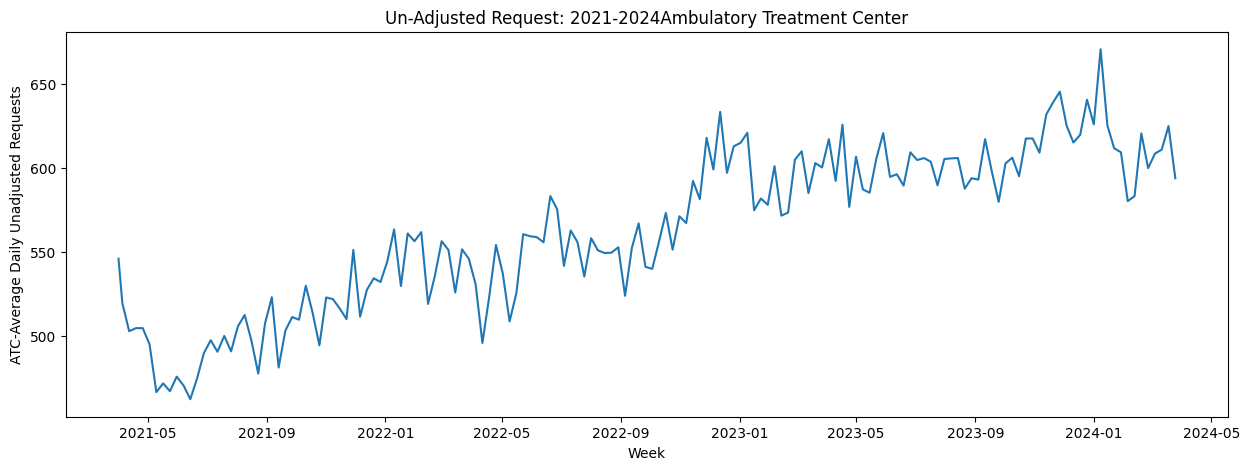

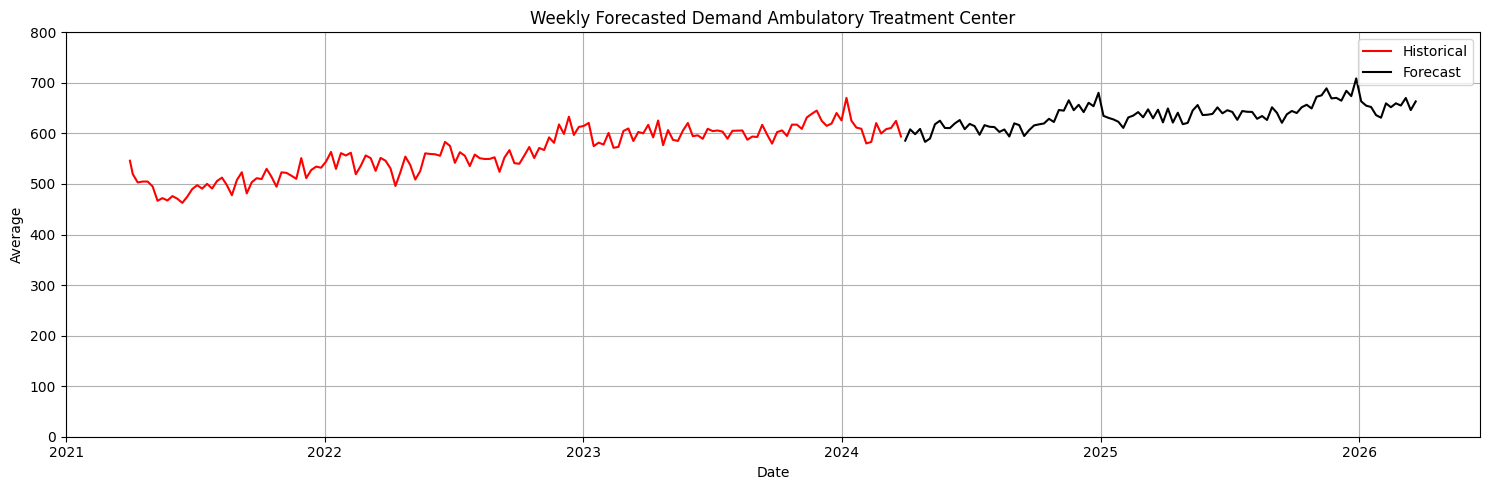

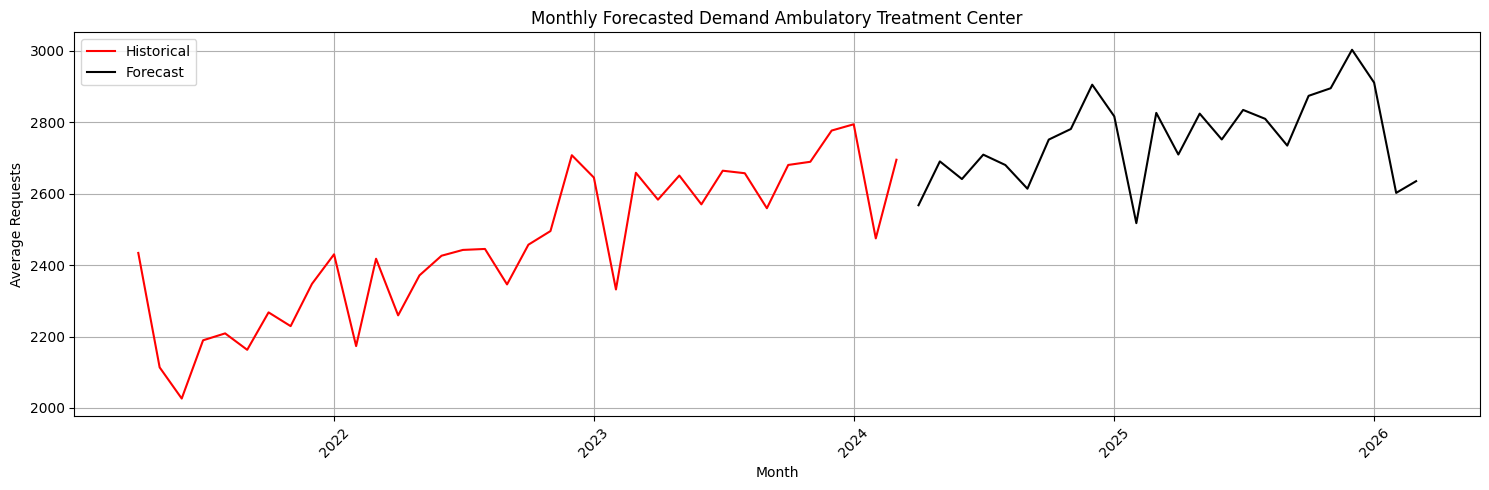

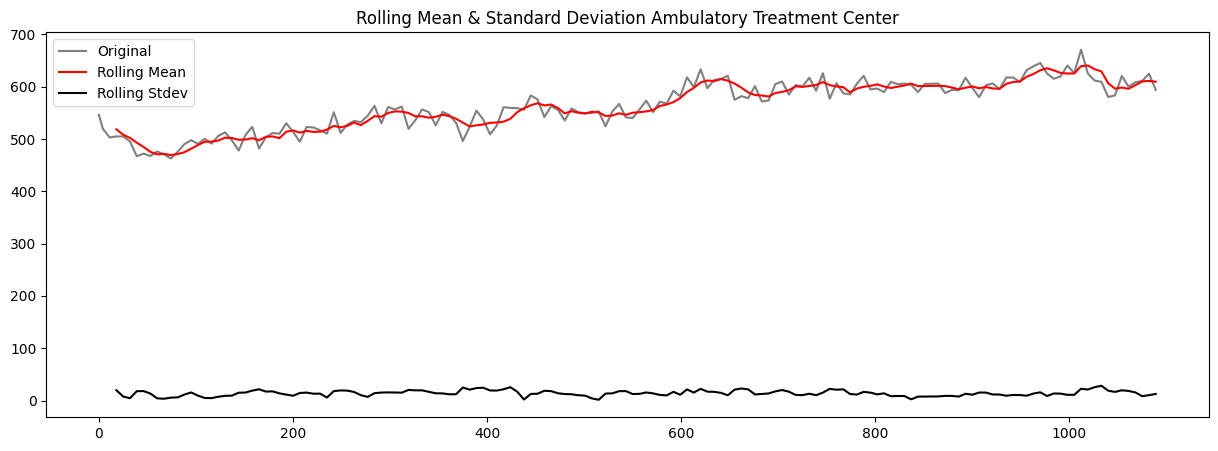

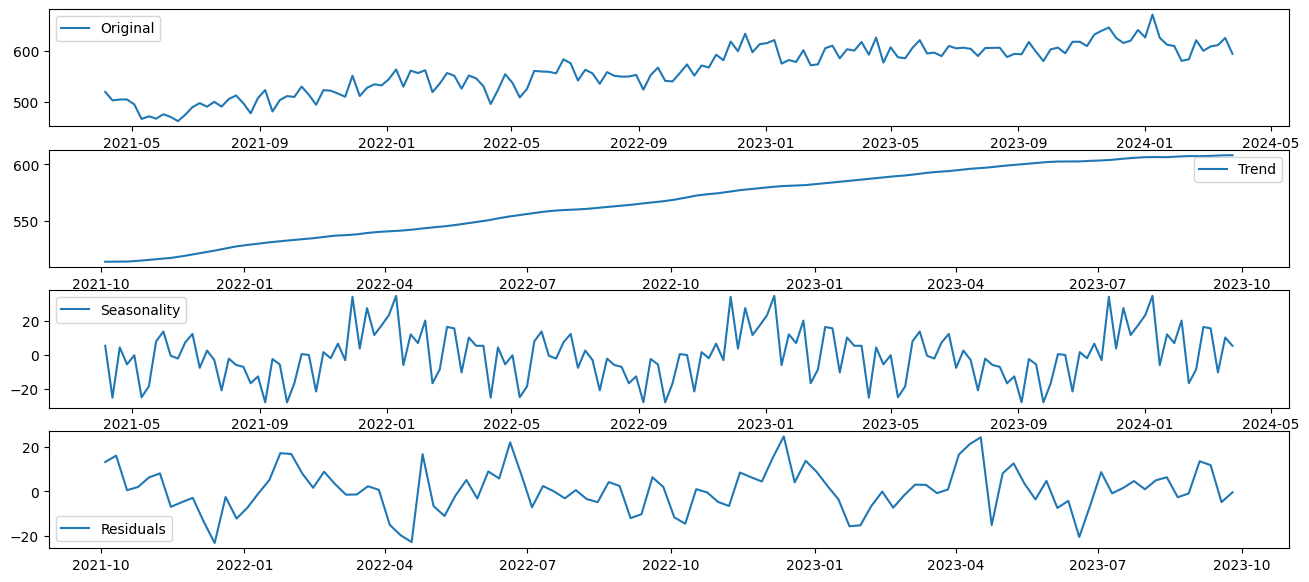

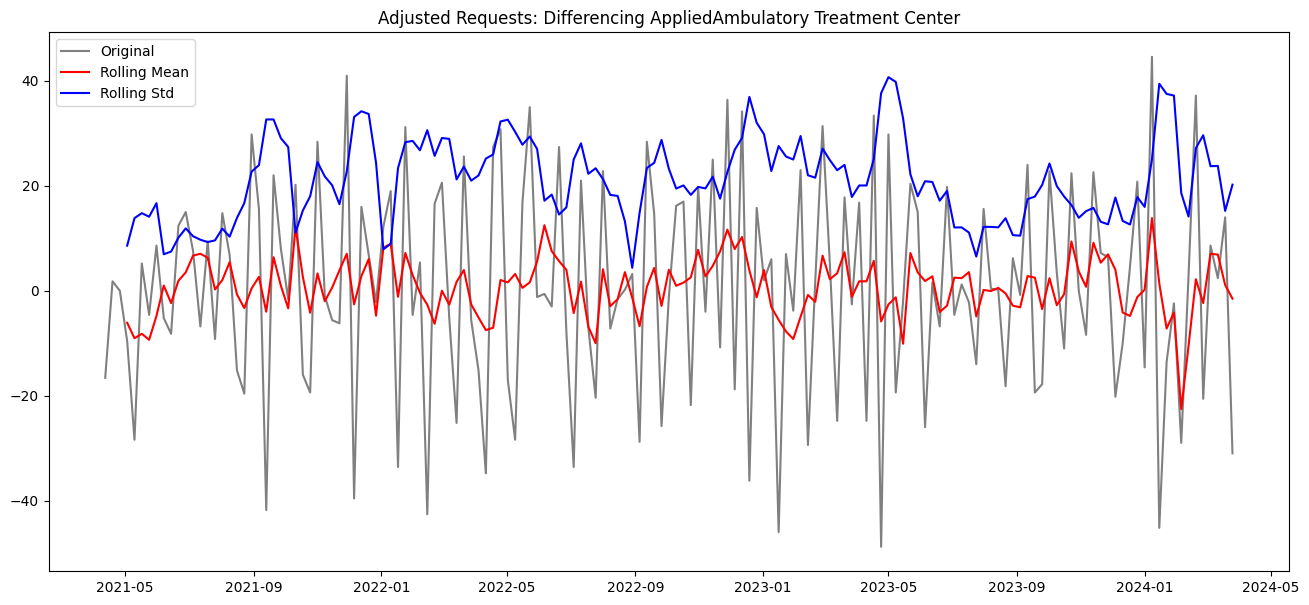

P-value:  8.087377455088065e-08
Function 'rungraphs' executed in 13 minute(s) and 38 second(s)


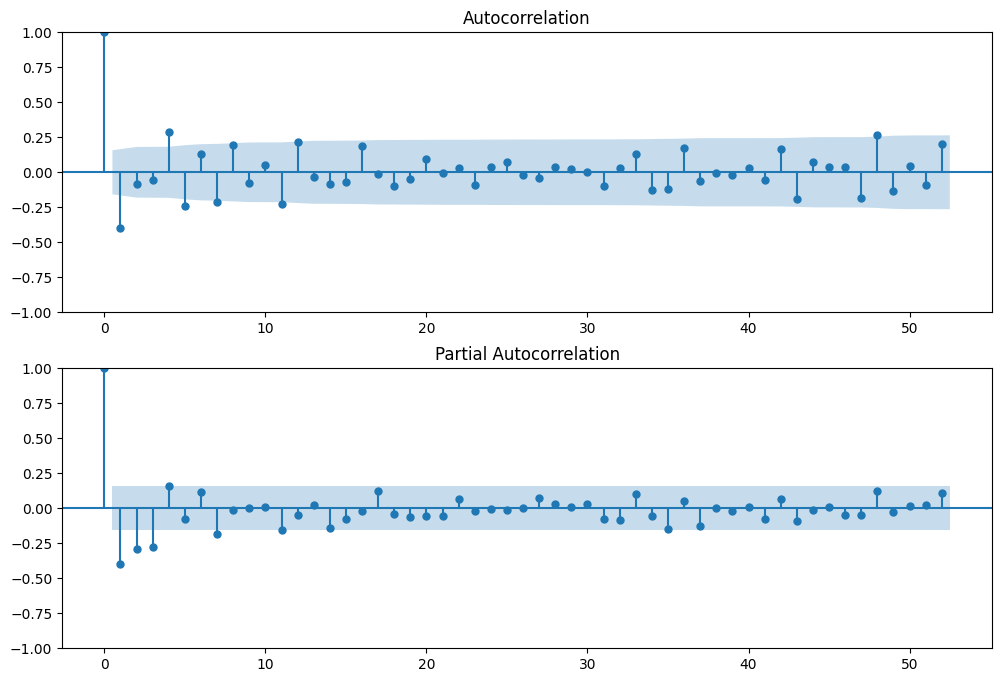

In [100]:
df = cleaned_data[0]

name = df_name_lst[0]
ATC_lst = rungraphs(df,name)

## MD Anderson Sugar Land

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=36.45 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=767.529, Time=0.60 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=746.991, Time=2.70 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=13.99 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=748.853, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=28.66 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=22.82 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=747.000, Time=3.87 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=750.976, Time=52.51 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=767.402, Time=3.66 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=736.070, Time=7.21 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=736.274, Time=0.72 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=147.42 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=44.83 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=736.14

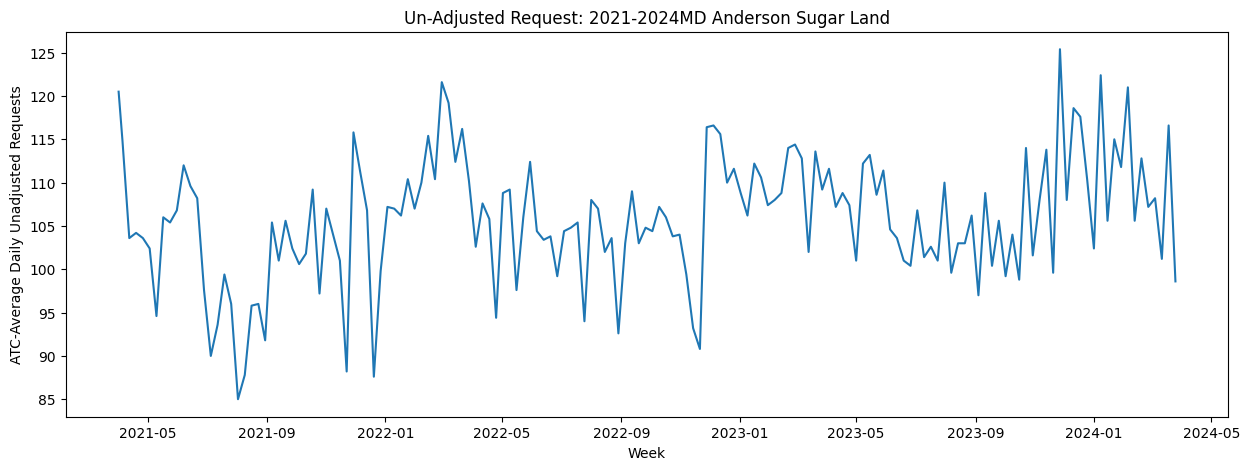

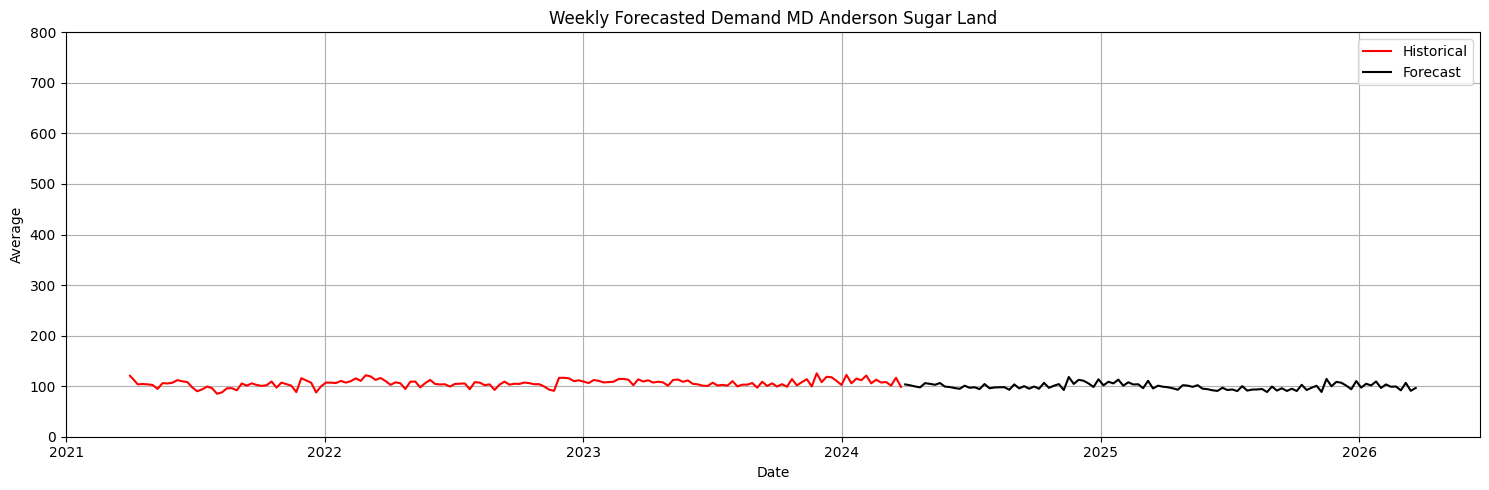

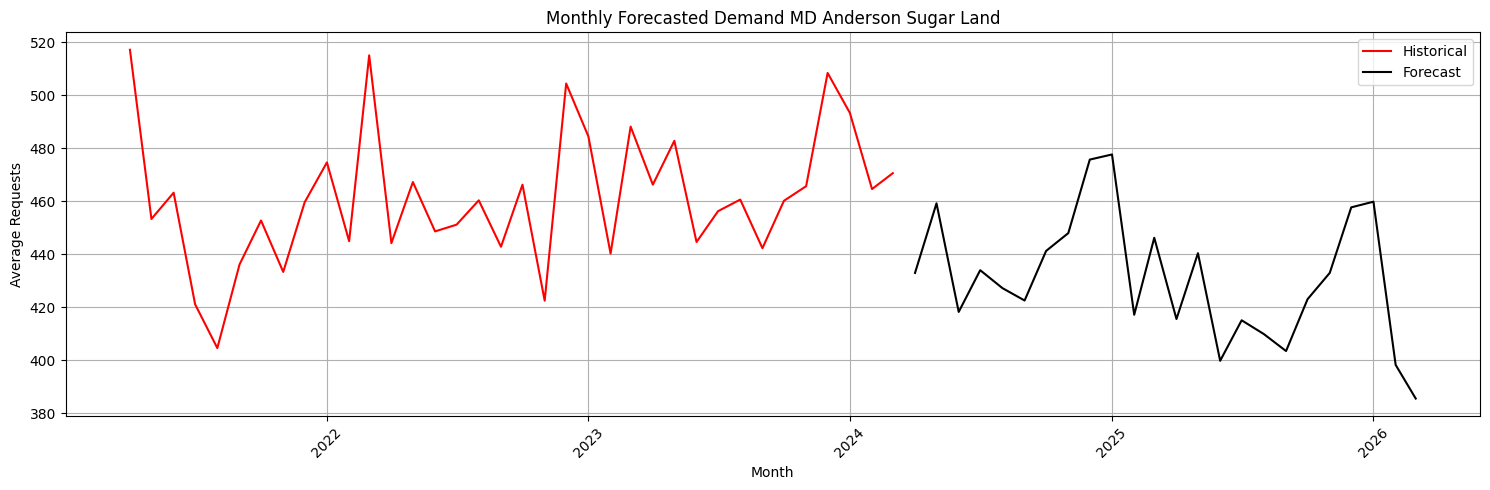

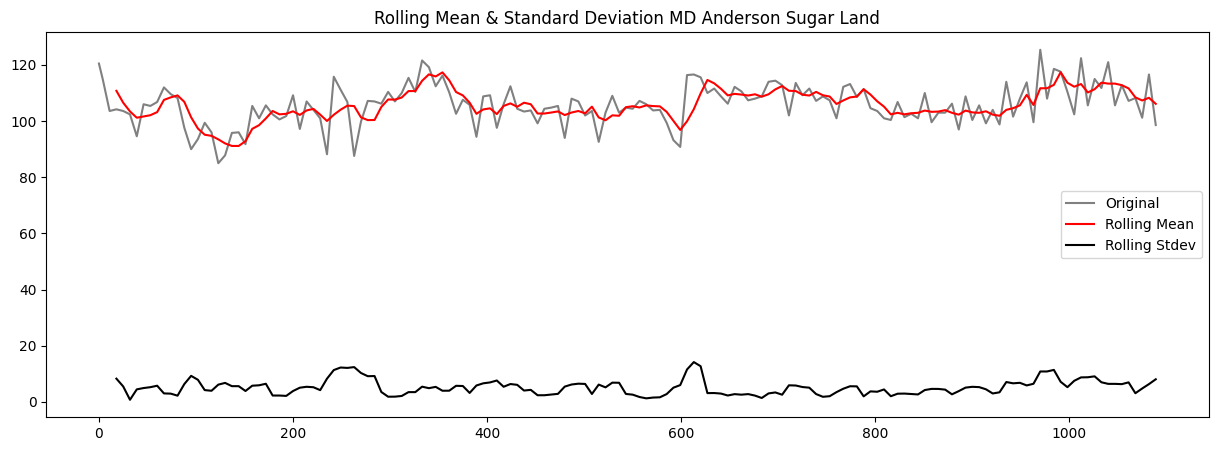

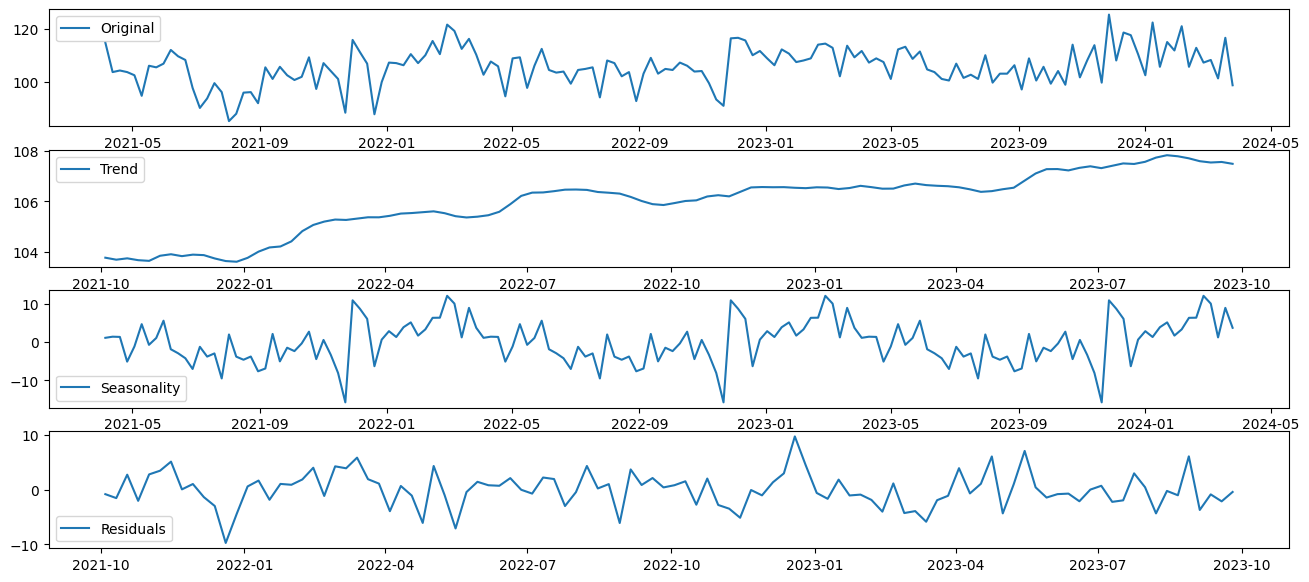

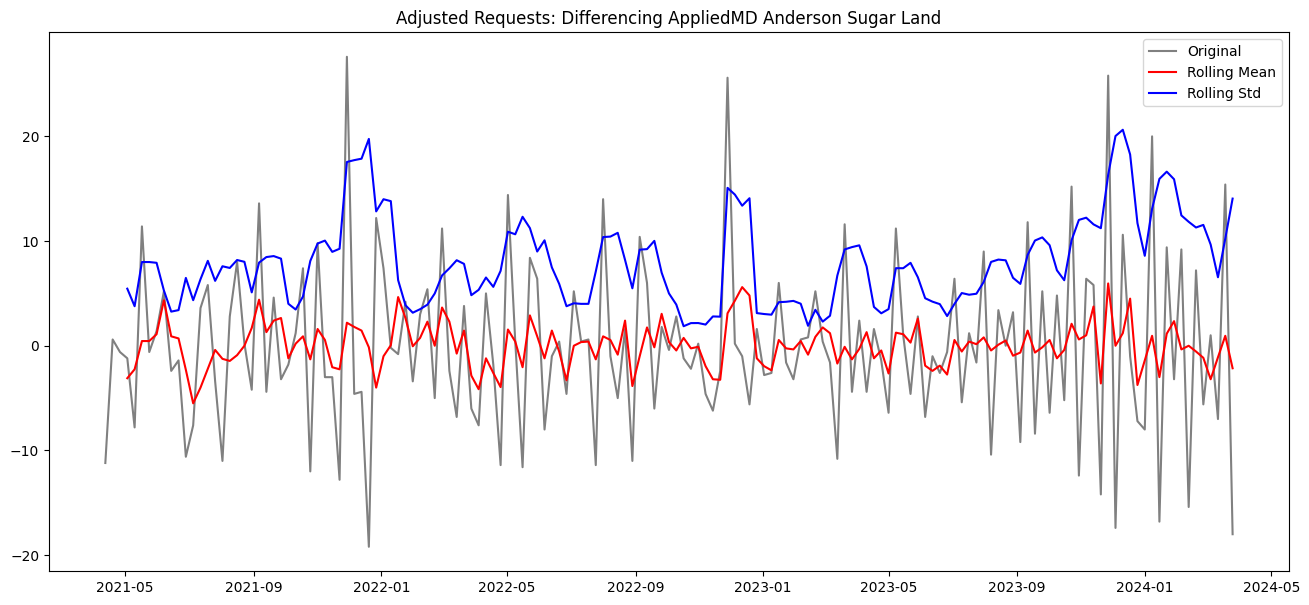

P-value:  6.172868442983273e-14
Function 'rungraphs' executed in 18 minute(s) and 48 second(s)


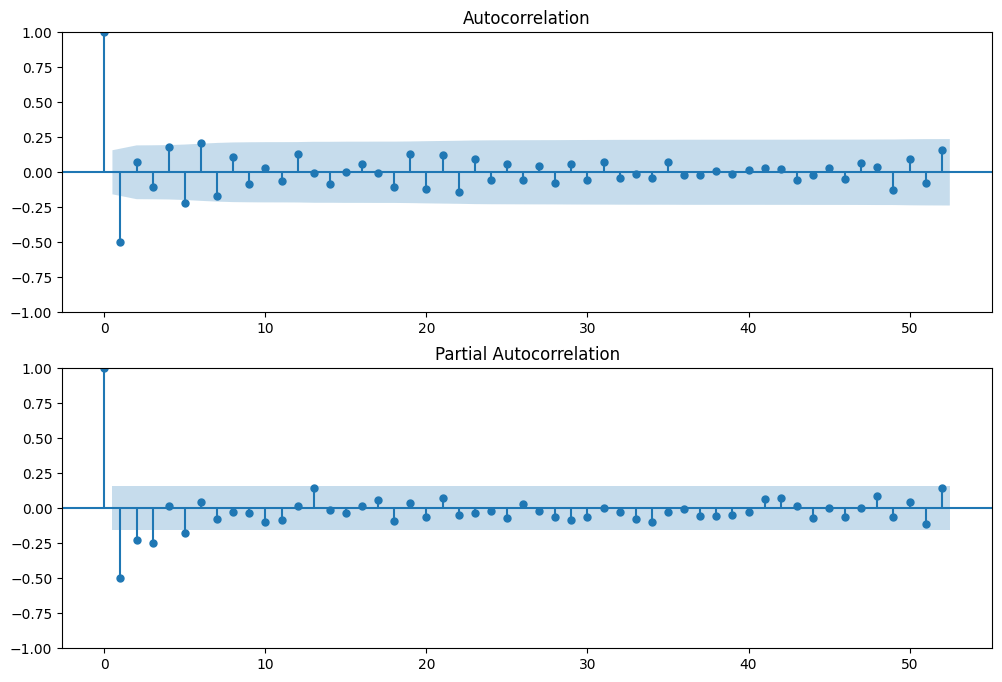

In [115]:
df = cleaned_data[1]
name = df_name_lst[1]
sugarland_lst = rungraphs(df,name)

## MD Anderson The Woodland

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=41.81 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=799.667, Time=0.95 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=782.204, Time=3.11 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=15.06 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=795.014, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=62.21 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=20.72 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=15.18 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=786.090, Time=59.36 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=790.676, Time=1.84 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=782.371, Time=3.93 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=773.352, Time=6.70 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=774.768, Time=75.77 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Ti

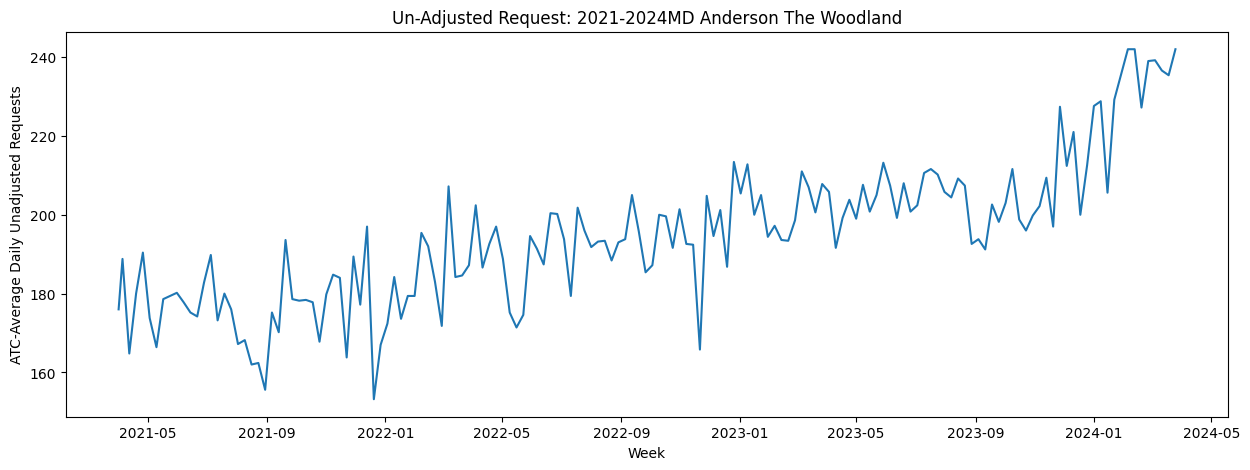

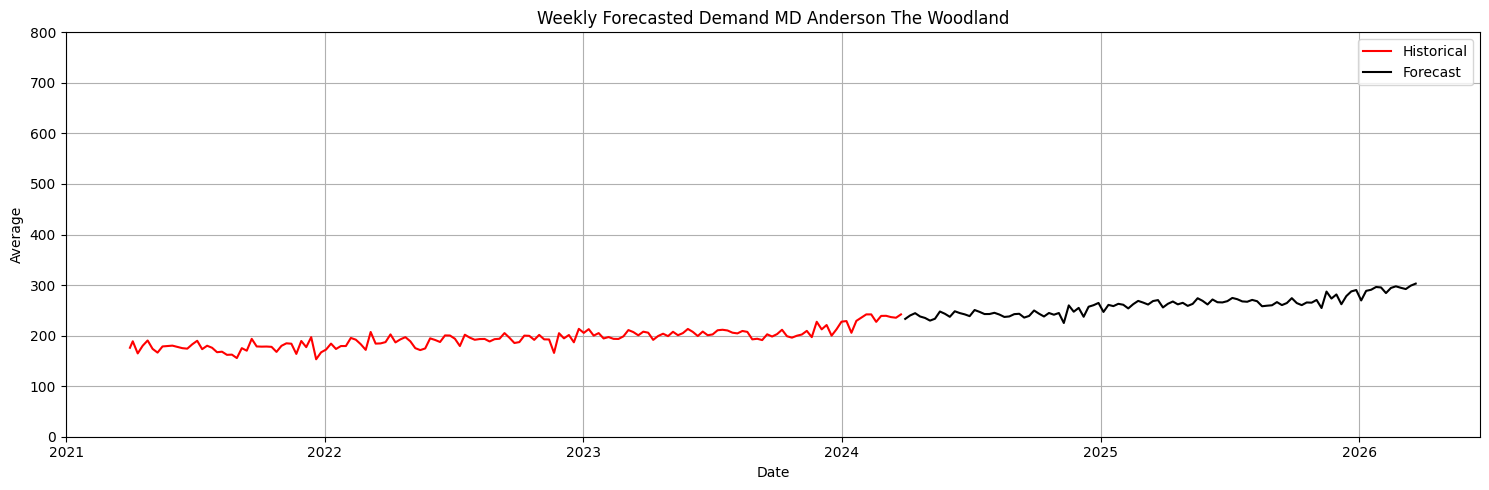

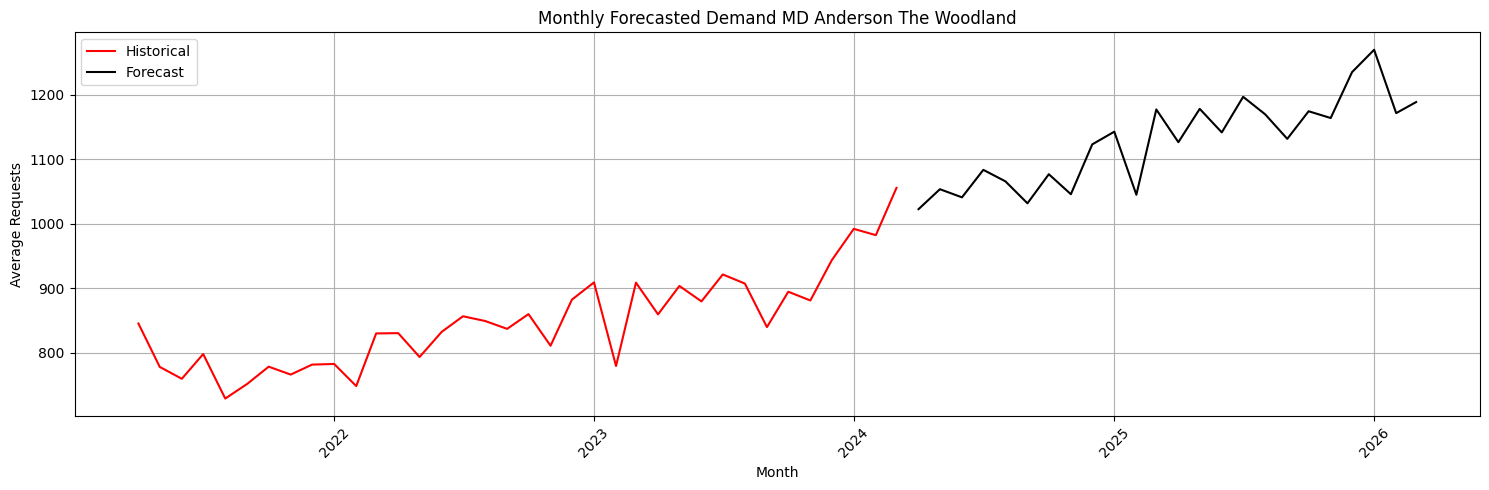

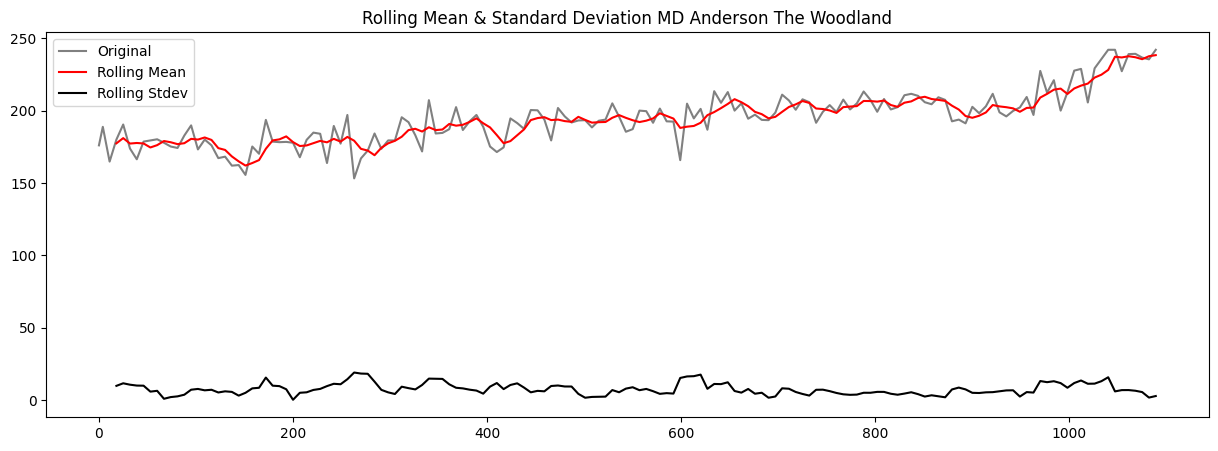

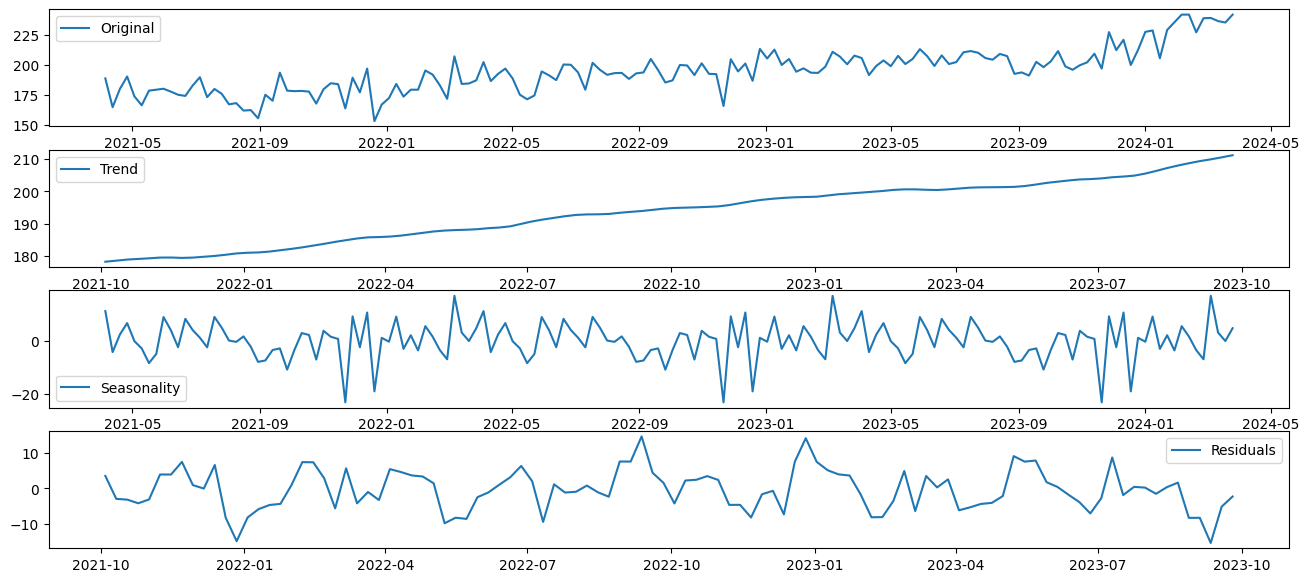

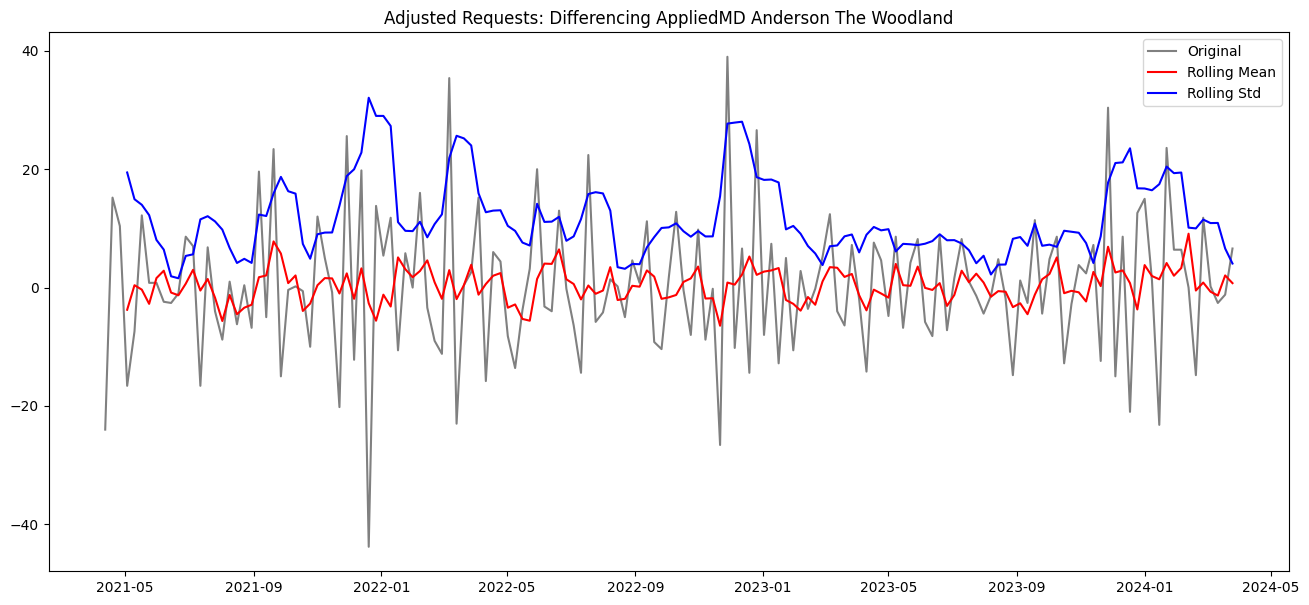

P-value:  5.616133562126581e-11
Function 'rungraphs' executed in 8 minute(s) and 17 second(s)


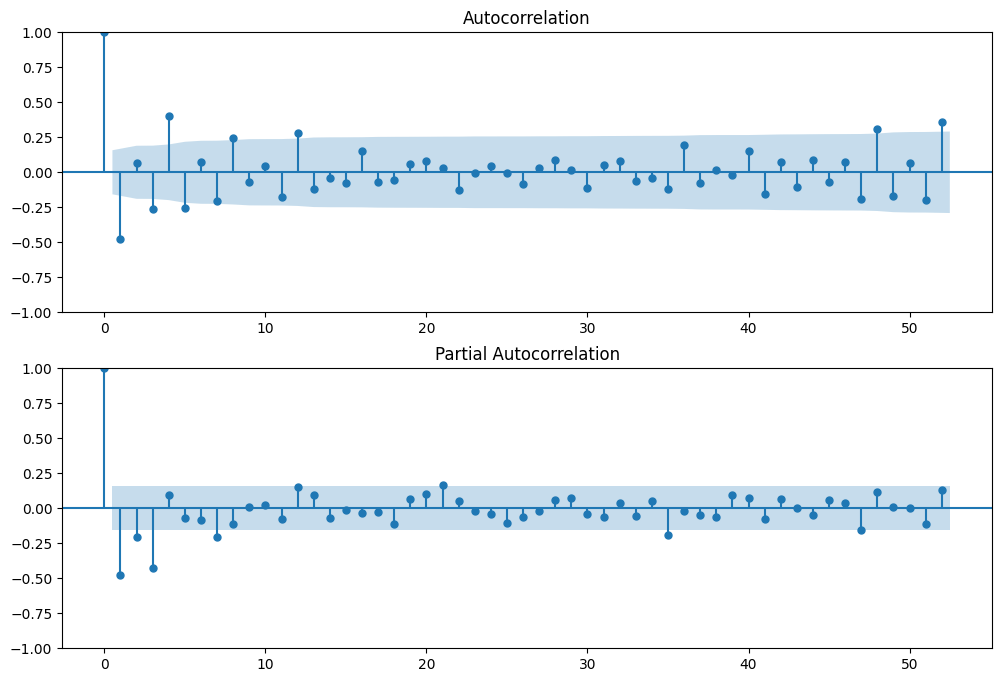

In [101]:
df = cleaned_data[2]
name = df_name_lst[2]
woodlands_lst = rungraphs(df,name)

## MD Anderson West Houston

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=29.48 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=848.383, Time=1.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=804.934, Time=2.78 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=799.859, Time=5.03 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=804.225, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=10.23 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=801.836, Time=11.05 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=800.006, Time=3.61 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=803.836, Time=17.54 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=845.732, Time=34.95 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=796.978, Time=7.33 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=803.407, Time=0.44 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=798.688, Time=11.84 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=798.688, Time=21.14 sec
 ARIMA(1,1,1)(1,1,0)[52]          

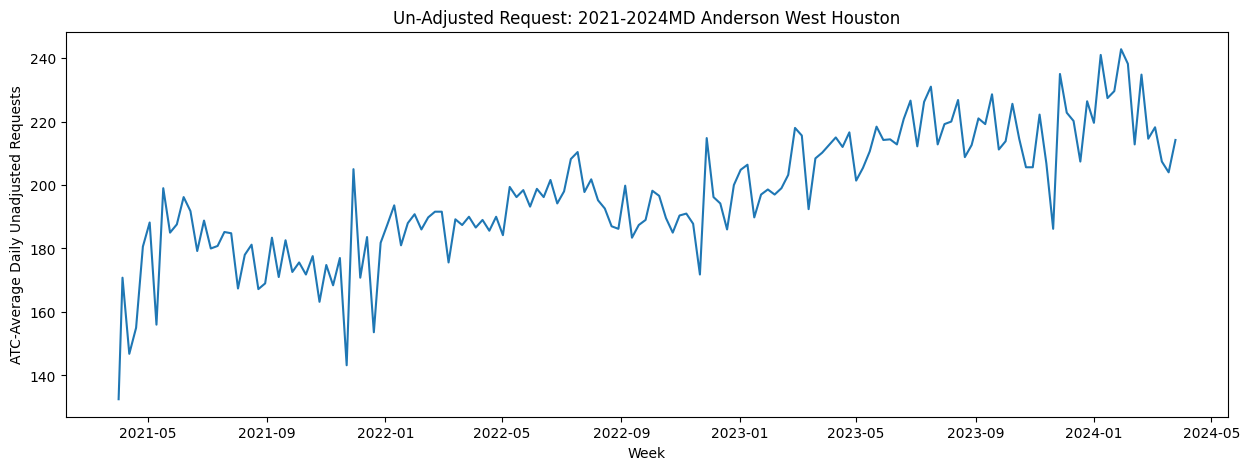

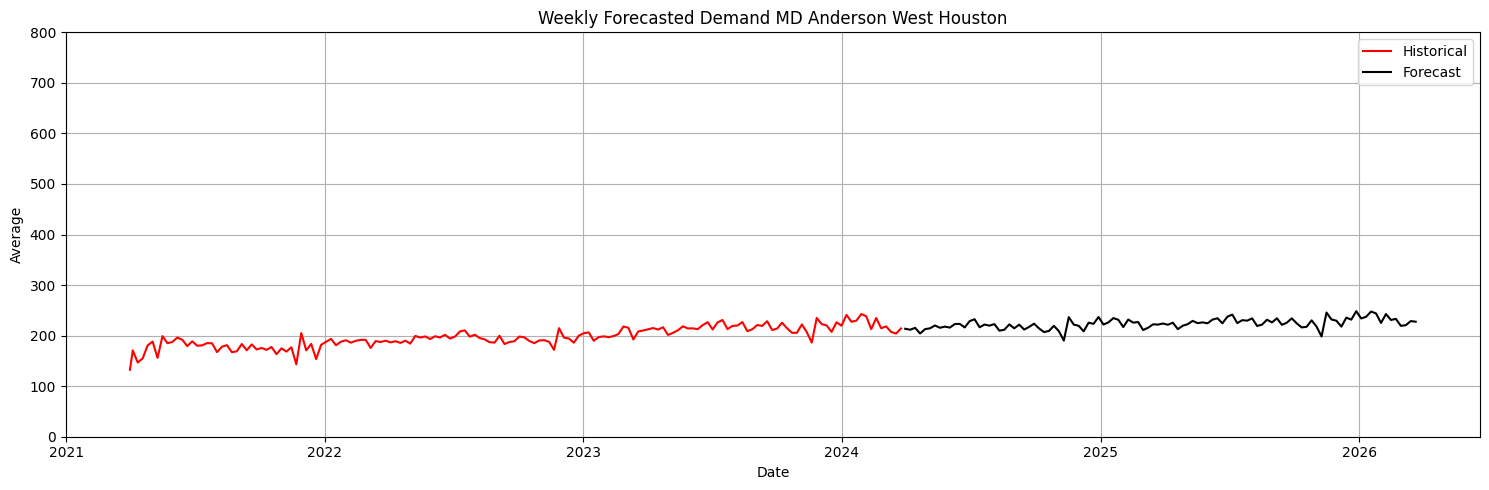

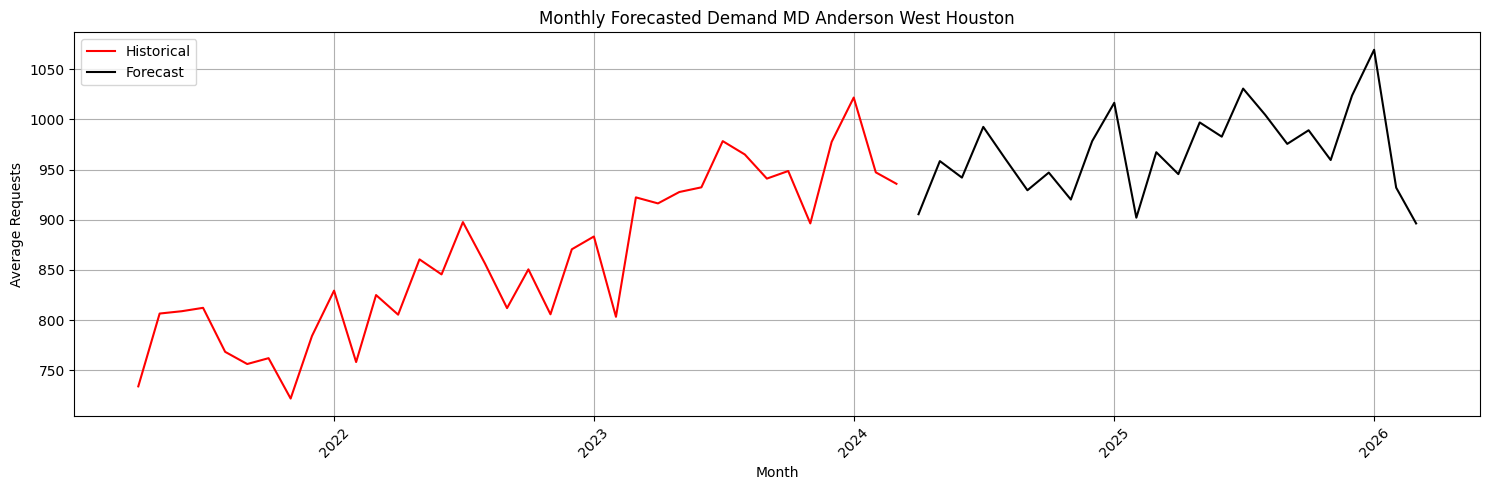

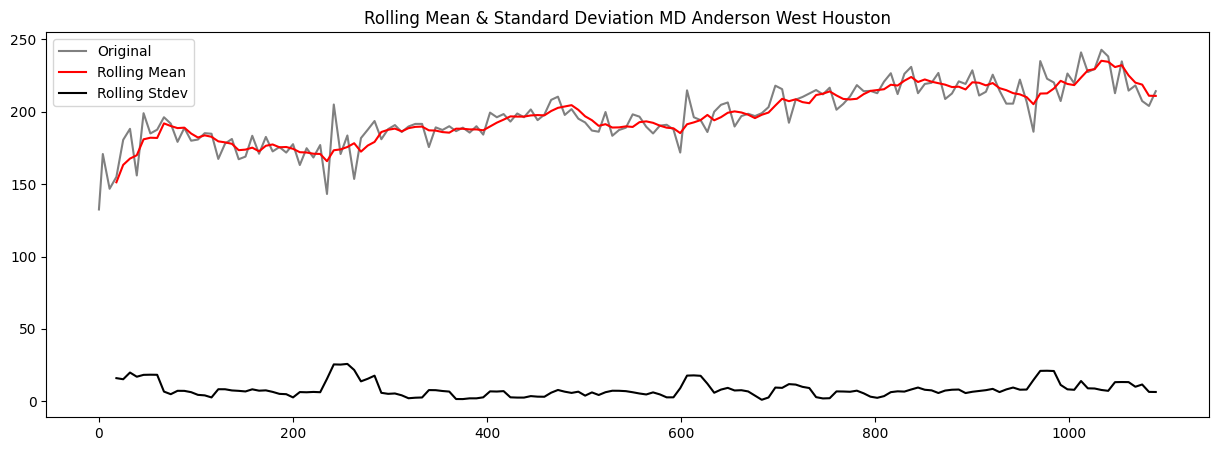

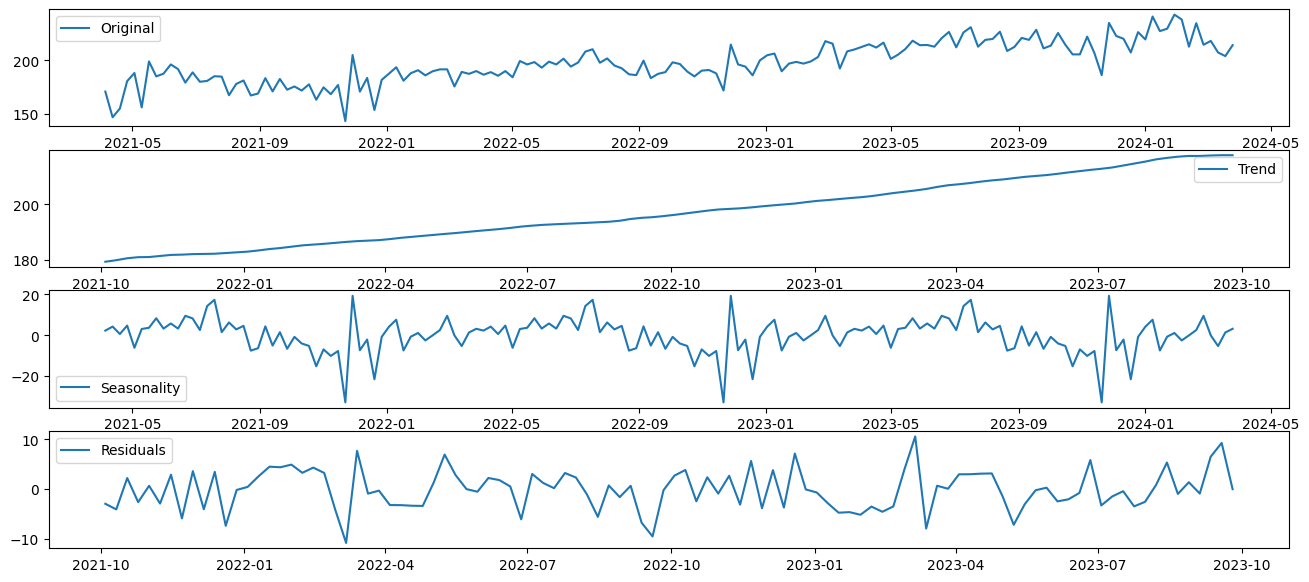

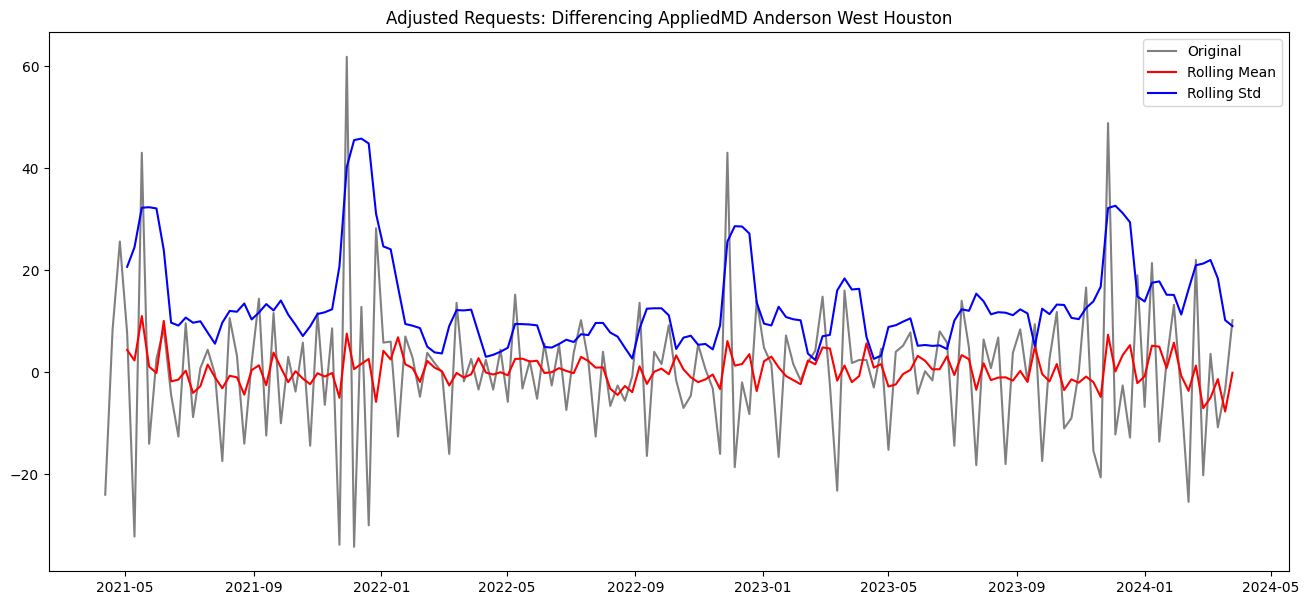

P-value:  0.003789407085666393
Function 'rungraphs' executed in 5 minute(s) and 56 second(s)


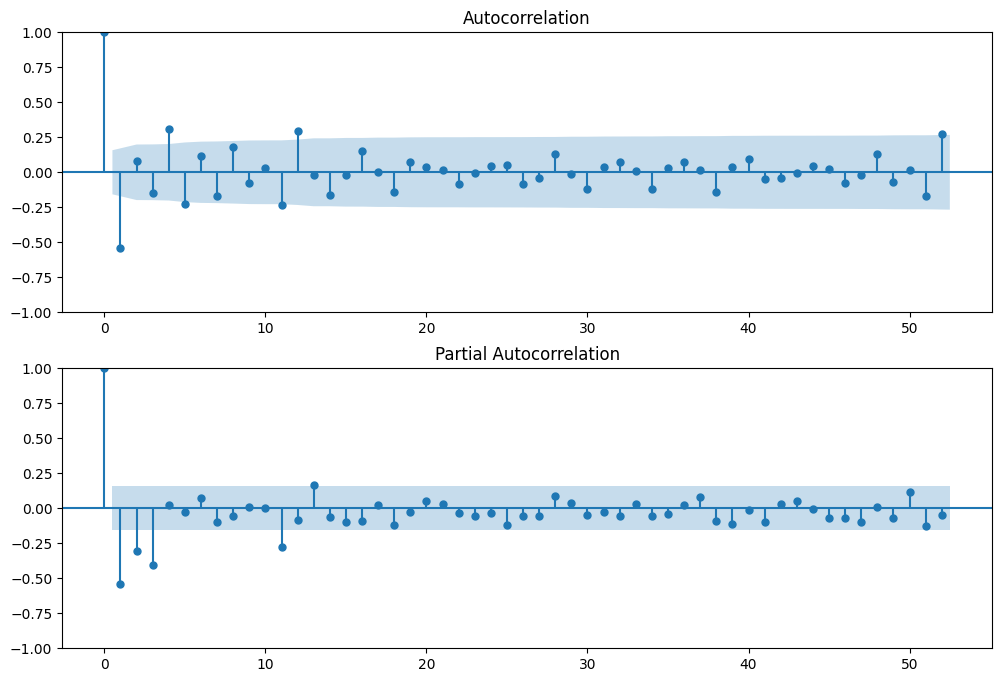

In [102]:
df = cleaned_data[3]
name = df_name_lst[3]
west_houston_lst = rungraphs(df,name)

## MD Anderson League City

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=785.172, Time=30.63 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=854.523, Time=1.29 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=797.029, Time=3.66 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=6.51 sec
 ARIMA(2,1,2)(0,1,1)[52]             : AIC=783.190, Time=23.09 sec
 ARIMA(2,1,2)(0,1,0)[52]             : AIC=789.471, Time=2.23 sec
 ARIMA(2,1,2)(0,1,2)[52]             : AIC=785.172, Time=88.10 sec
 ARIMA(2,1,2)(1,1,0)[52]             : AIC=783.223, Time=15.57 sec
 ARIMA(2,1,2)(1,1,2)[52]             : AIC=787.172, Time=90.72 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=781.192, Time=10.76 sec
 ARIMA(1,1,2)(0,1,0)[52]             : AIC=787.491, Time=1.35 sec
 ARIMA(1,1,2)(1,1,1)[52]             : AIC=783.173, Time=13.86 sec
 ARIMA(1,1,2)(0,1,2)[52]             : AIC=783.173, Time=36.00 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=781.224, Time=10.06 sec
 ARIMA(1,1,2)(1,1,2)[52]    

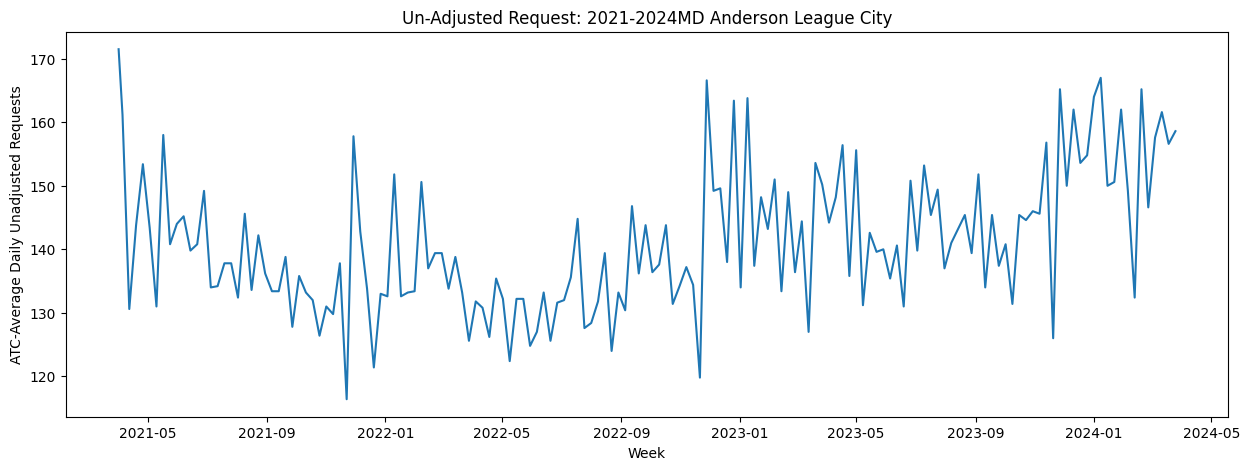

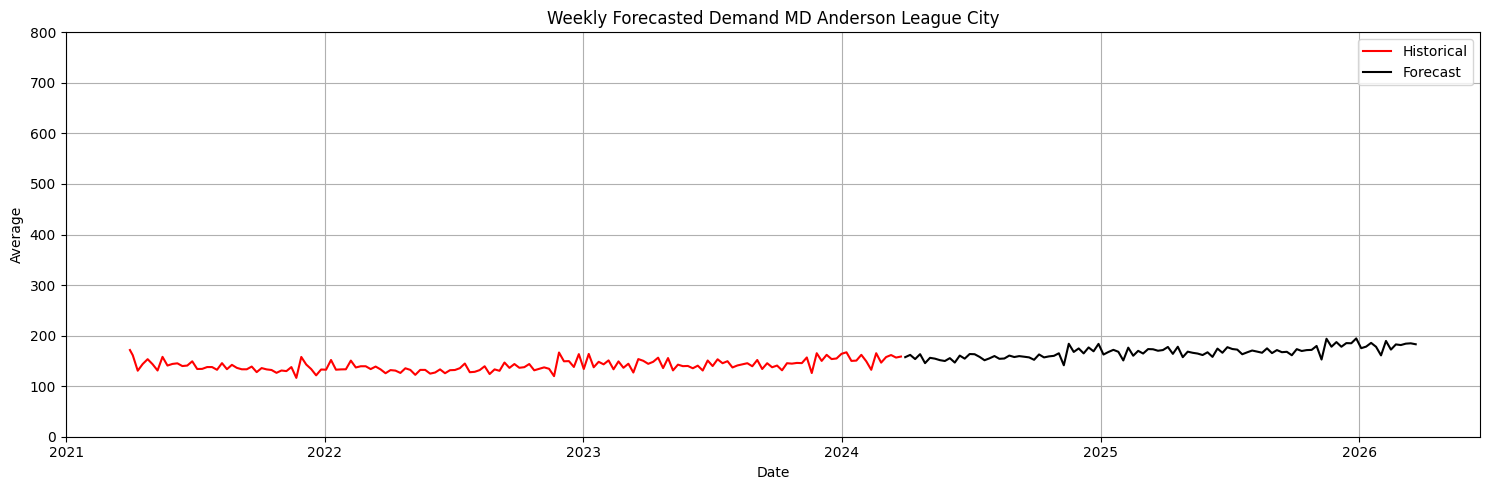

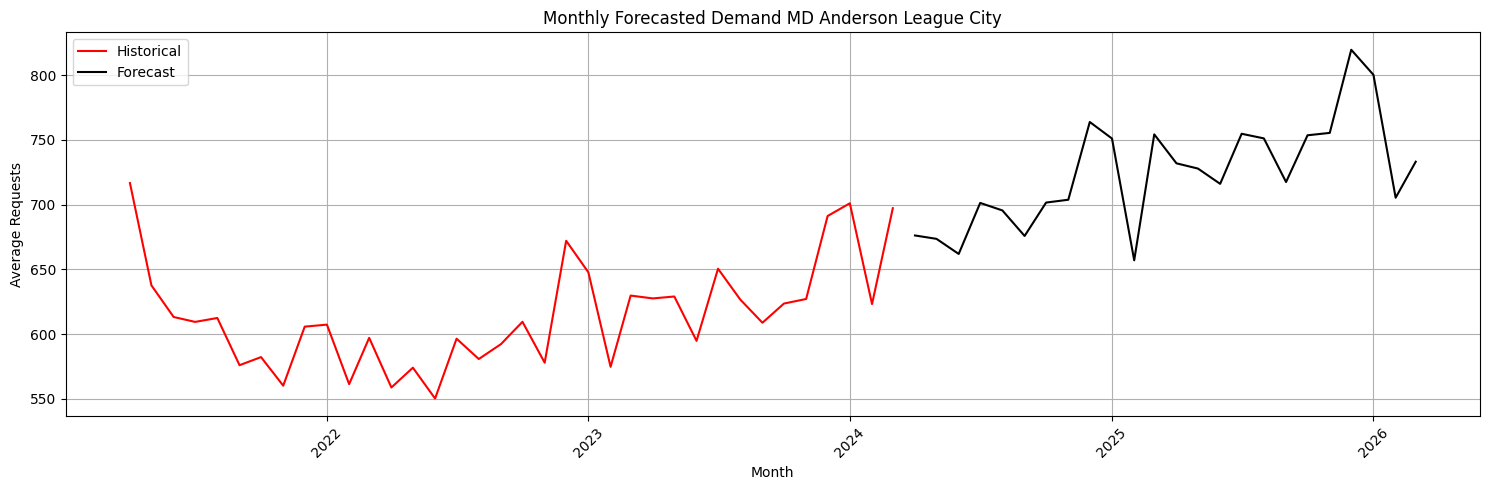

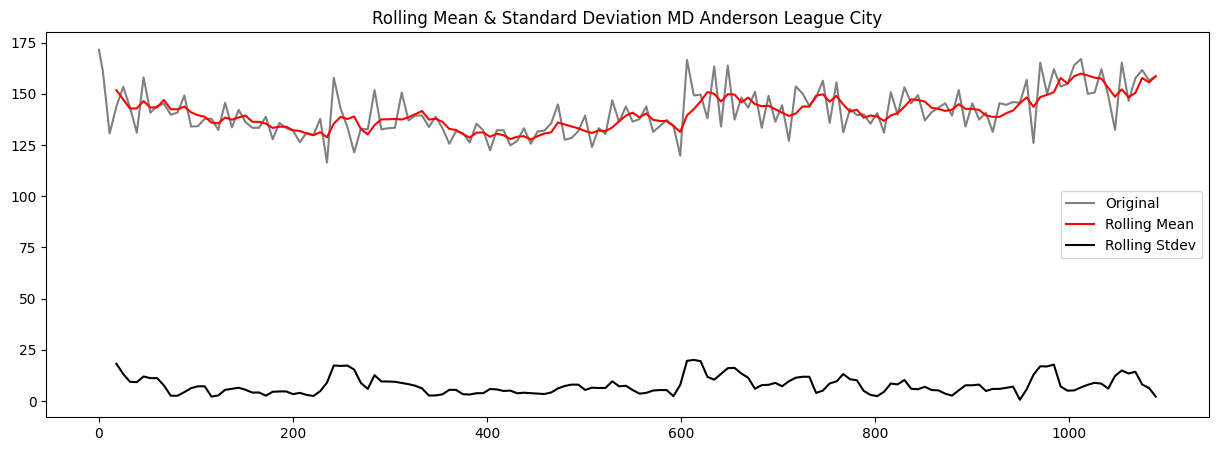

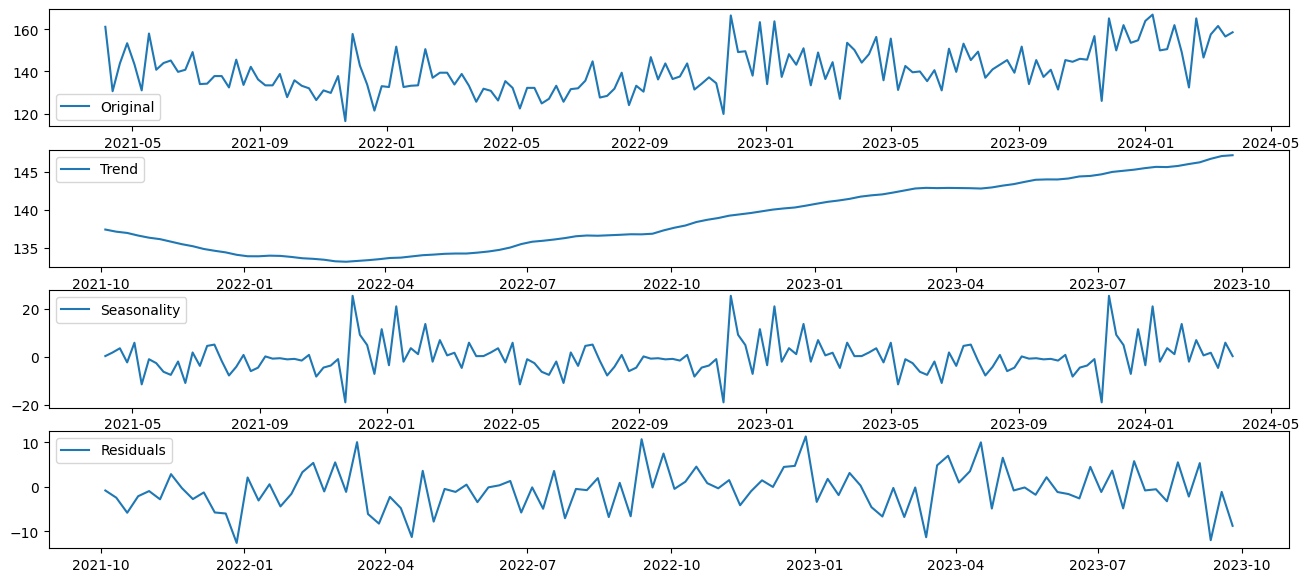

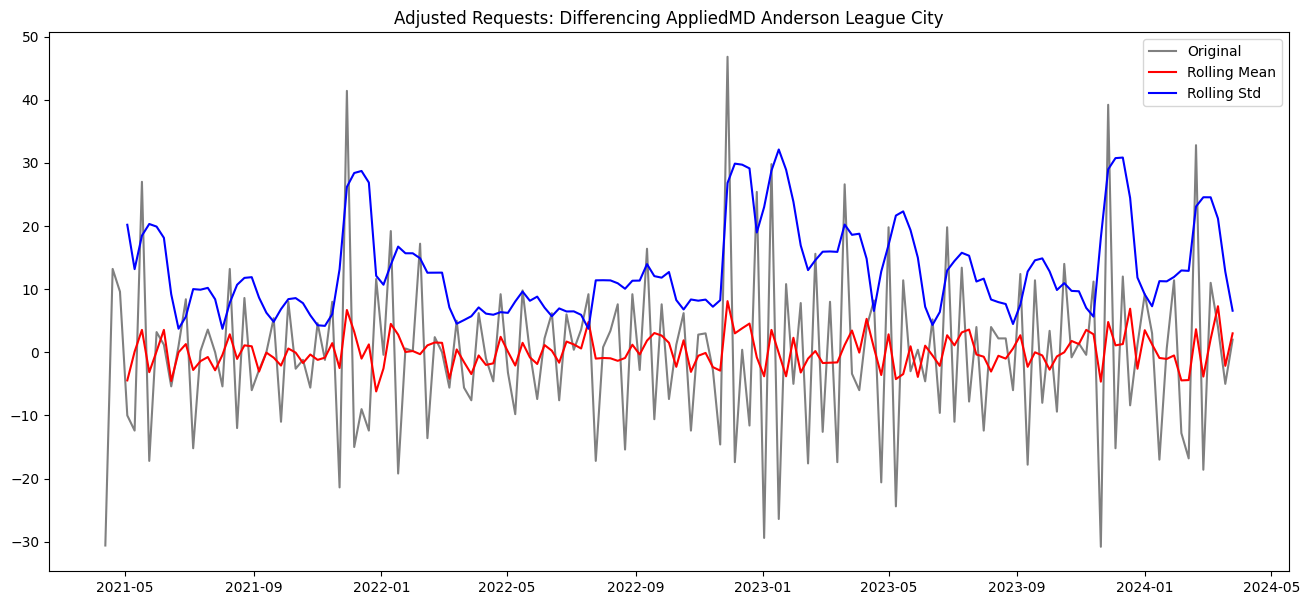

P-value:  7.530239637508733e-08
Function 'rungraphs' executed in 11 minute(s) and 45 second(s)


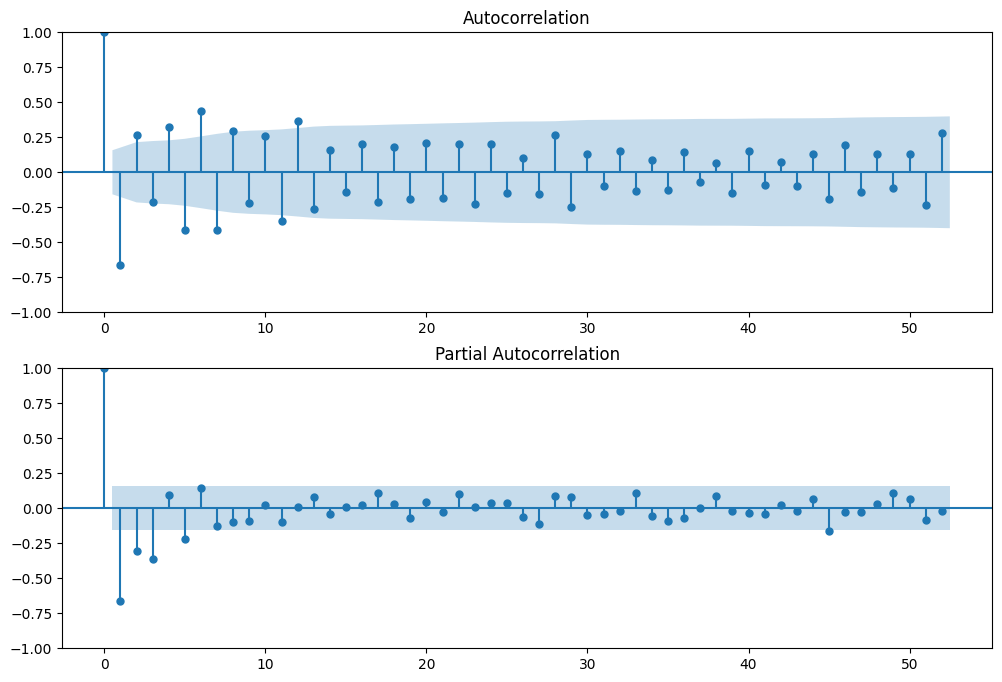

In [103]:
df = cleaned_data[4]
name = df_name_lst[4]
league_city_lst = rungraphs(df,name)

In [112]:
sugarland_lst[-1]

,date,average_requests
0,2021-04-01,517.100000
1,2021-04-01,453.257143
2,2021-04-01,463.171429
3,2021-04-01,421.057143
4,2021-04-01,404.542857
5,2021-04-01,436.085714
6,2021-04-01,452.685714
7,2021-04-01,433.285714
8,2021-04-01,459.600000
9,2021-04-01,474.600000


# Saving Excel Files

In [ ]:
# monthly_df1 = ATC_lst[-1]
# monthly_df2 = sugarland_lst[-1]
# monthly_df3 = woodlands_lst[-1]
# monthly_df4 = league_city_lst[-1]
# monthly_df5 = west_houston_lst[-1]

# save_excel_file(monthly_df2, 'Sugar_Land')


